## Comporative study of MVO, Risk parity and equal weighted portfolio

[*********************100%***********************]  5 of 5 completed


--- Maximum Sharpe Ratio Portfolio ---
Weight of RELIANCE.NS: 23.51%
Weight of HDFCBANK.NS: 11.80%
Weight of INFY.NS: 64.69%
Weight of TCS.NS: 0.00%
Weight of ITC.NS: 0.00%
Annualized Return: 17.77%
Annualized Volatility: 16.48%
Sharpe Ratio: 1.0783
--------------------------------------


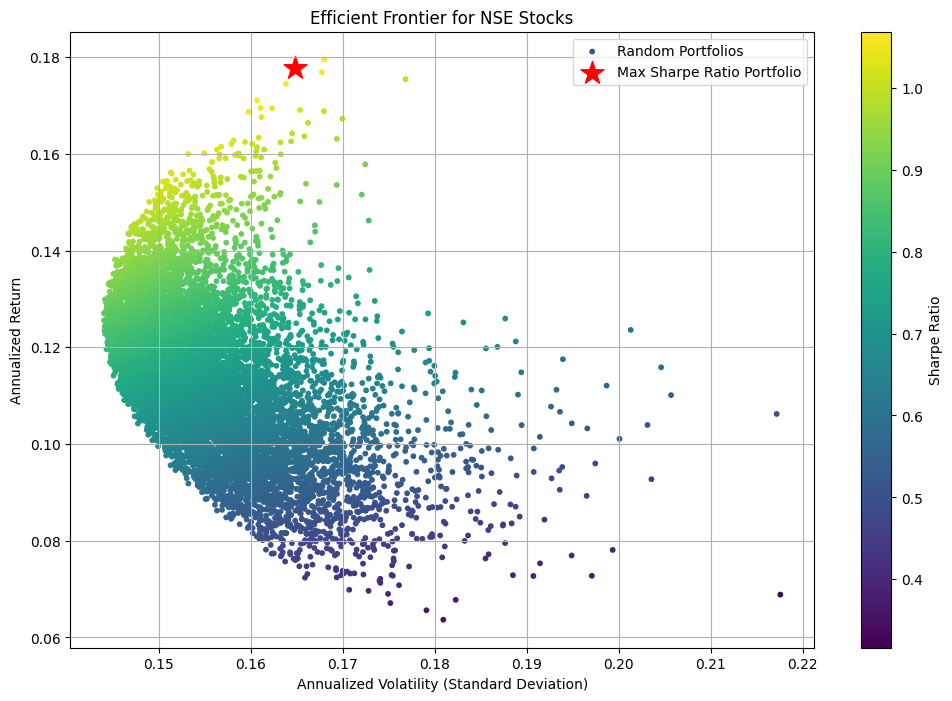

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import yfinance as yf

# List of NSE stock tickers with the .NS suffix
tickers = ['RELIANCE.NS', 'HDFCBANK.NS', 'INFY.NS', 'TCS.NS', 'ITC.NS']

# Download historical 'Adj Close' prices for the last 5 years
data = yf.download(tickers, period="5y", auto_adjust=False)['Adj Close']

# Calculate daily logarithmic returns
log_returns = np.log(data / data.shift(1)).dropna()

# Annualize expected returns and covariance
# Assuming 252 trading days in a year for the Indian market
annual_returns = log_returns.mean() * 252
annual_cov = log_returns.cov() * 252

# Number of assets
num_assets = len(tickers)

# --- Mean-Variance Optimization Functions ---

def portfolio_return(weights, returns):
    return np.sum(weights * returns)

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def negative_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate=0.0):
    p_return = portfolio_return(weights, returns)
    p_volatility = portfolio_volatility(weights, cov_matrix)
    return -(p_return - risk_free_rate) / p_volatility

# --- Optimization for Maximum Sharpe Ratio Portfolio ---

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for asset in range(num_assets))
initial_weights = np.array(num_assets * [1. / num_assets,])

optimal_sharpe = minimize(
    negative_sharpe_ratio,
    initial_weights,
    args=(annual_returns, annual_cov),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# Extract and print results for the max Sharpe portfolio
max_sharpe_weights = optimal_sharpe.x
max_sharpe_return = portfolio_return(max_sharpe_weights, annual_returns)
max_sharpe_volatility = portfolio_volatility(max_sharpe_weights, annual_cov)
max_sharpe_value = -negative_sharpe_ratio(max_sharpe_weights, annual_returns, annual_cov)

print("--- Maximum Sharpe Ratio Portfolio ---")
for i, ticker in enumerate(tickers):
    print(f"Weight of {ticker}: {max_sharpe_weights[i]:.2%}")
print(f"Annualized Return: {max_sharpe_return:.2%}")
print(f"Annualized Volatility: {max_sharpe_volatility:.2%}")
print(f"Sharpe Ratio: {max_sharpe_value:.4f}")
print("--------------------------------------")

# --- Plotting the Efficient Frontier ---

num_portfolios = 10000
results = np.zeros((3, num_portfolios))
for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)

    p_return = portfolio_return(weights, annual_returns)
    p_volatility = portfolio_volatility(weights, annual_cov)

    results[0,i] = p_volatility
    results[1,i] = p_return
    results[2,i] = (p_return - 0) / p_volatility

plt.figure(figsize=(12, 8))
plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='viridis', s=10, label='Random Portfolios')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(max_sharpe_volatility, max_sharpe_return, c='red', marker='*', s=300, label='Max Sharpe Ratio Portfolio')
plt.title('Efficient Frontier for NSE Stocks')
plt.xlabel('Annualized Volatility (Standard Deviation)')
plt.ylabel('Annualized Return')
plt.legend()
plt.grid(True)
plt.show()

### Alternative Allocations

#### Equally Weighted portfolio

In [6]:
# Download historical adjusted close prices
#data = yf.download(tickers, start="2018-01-01", end="2025-01-01")['Adj Close']

# Calculate daily returns
#returns = data.pct_change().dropna()

# Equal weights
n = len(tickers)
equal_weights = np.array([1/n] * n)


# Expected annualized return
annual_return_eq = np.dot(equal_weights, log_returns.mean()) * 252

# Expected annualized volatility
cov_matrix = log_returns.cov()
annual_volatility_eq = np.sqrt(np.dot(equal_weights.T, np.dot(cov_matrix * 252, equal_weights)))

# Assume risk-free rate (e.g., 6% = 0.06 for India)
risk_free_rate = 0.06
sharpe_ratio_eq = (annual_return - risk_free_rate) / annual_volatility

# Print results
print("--- Equal Weighted Portfolio ---")
for ticker, weight in zip(tickers, equal_weights):
    print(f"Weight of {ticker}: {weight*100:.2f}%")
print(f"Annualized Return: {annual_return_eq*100:.2f}%")
print(f"Annualized Volatility: {annual_volatility_eq*100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_eq:.4f}")


--- Equal Weighted Portfolio ---
Weight of RELIANCE.NS: 20.00%
Weight of HDFCBANK.NS: 20.00%
Weight of INFY.NS: 20.00%
Weight of TCS.NS: 20.00%
Weight of ITC.NS: 20.00%
Annualized Return: 11.31%
Annualized Volatility: 14.89%
Sharpe Ratio: 0.3694


In [7]:
# Compute daily log returns
#log_returns = np.log(data / data.shift(1)).dropna()

# Compute volatilities (standard deviation of log returns)
daily_vols = log_returns.std()

# Inverse volatility weights
inv_vol = 1 / daily_vols
risk_parity_weights = inv_vol / inv_vol.sum()

# Portfolio annualized return
annual_return_rp = np.dot(risk_parity_weights, log_returns.mean()) * 252

# Portfolio annualized volatility
cov_matrix = log_returns.cov() * 252
annual_volatility_rp = np.sqrt(np.dot(risk_parity_weights.T, np.dot(cov_matrix, risk_parity_weights)))

# Assume risk-free rate (example: 6% = 0.06 for India)
risk_free_rate = 0.06
sharpe_ratio_rp = (annual_return - risk_free_rate) / annual_volatility

# Print results
print("--- Risk Parity (Inverse Volatility) Portfolio ---")
for ticker, weight in zip(tickers, risk_parity_weights):
    print(f"Weight of {ticker}: {weight*100:.2f}%")
print(f"Annualized Return: {annual_return*100:.2f}%")
print(f"Annualized Volatility: {annual_volatility*100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")


--- Risk Parity (Inverse Volatility) Portfolio ---
Weight of RELIANCE.NS: 20.23%
Weight of HDFCBANK.NS: 18.33%
Weight of INFY.NS: 21.45%
Weight of TCS.NS: 19.02%
Weight of ITC.NS: 20.97%
Annualized Return: 11.46%
Annualized Volatility: 14.79%
Sharpe Ratio: 0.3694


### Comparison of three portfolios

Portfolio Comparison (returns, volatility, Sharpe ratio) and Portfolio Weights Comparison (allocation per stock).

In [10]:
import pandas as pd

# --- Collect results into a dictionary ---

results = {
    "MVO (Max Sharpe)": {
        "Weights": dict(zip(tickers, max_sharpe_weights)),
        "Annual Return": max_sharpe_return,
        "Annual Volatility": max_sharpe_volatility,
        "Sharpe Ratio": max_sharpe_value
    },
    "Equal Weighted": {
        "Weights": dict(zip(tickers, equal_weights)),
        "Annual Return": annual_return_eq,
        "Annual Volatility": annual_volatility_eq,
        "Sharpe Ratio": sharpe_ratio_eq
    },
    "Risk Parity": {
        "Weights": dict(zip(tickers, risk_parity_weights)),
        "Annual Return": annual_return_rp,
        "Annual Volatility": annual_volatility_rp,
        "Sharpe Ratio": sharpe_ratio_rp
    }
}

# --- Convert results to a DataFrame for comparison ---
comparison = pd.DataFrame({
    strategy: {
        "Annual Return": vals["Annual Return"],
        "Annual Volatility": vals["Annual Volatility"],
        "Sharpe Ratio": vals["Sharpe Ratio"]
    }
    for strategy, vals in results.items()
}).T

# Format for readability
comparison = comparison.map(lambda x: f"{x*100:.2f}%" if isinstance(x, float) else x)

print("\n--- Portfolio Comparison ---")
print(comparison)

# --- Weights Table ---
weights_df = pd.DataFrame({
    strategy: vals["Weights"]
    for strategy, vals in results.items()
}).T

weights_df = weights_df.map(lambda x: f"{x*100:.2f}%" if isinstance(x, float) else x)

print("\n--- Portfolio Weights Comparison ---")
print(weights_df)



--- Portfolio Comparison ---
                 Annual Return Annual Volatility Sharpe Ratio
MVO (Max Sharpe)        17.77%            16.48%      107.83%
Equal Weighted          11.31%            14.89%       36.94%
Risk Parity             11.46%            14.79%       36.94%

--- Portfolio Weights Comparison ---
                 RELIANCE.NS HDFCBANK.NS INFY.NS  TCS.NS  ITC.NS
MVO (Max Sharpe)      23.51%      11.80%  64.69%   0.00%   0.00%
Equal Weighted        20.00%      20.00%  20.00%  20.00%  20.00%
Risk Parity           20.23%      18.33%  21.45%  19.02%  20.97%


# Portfolio Construction Methods: Variants and Investment Objectives

**Each of these variants has a core principle but adapts to specific investment goals such as risk minimization, diversification, view incorporation, or simple budgeting.**

### 1. **Mean-Variance Optimization (MVO) Variants**

**Core Concept:**  
MVO aims to find the optimal portfolio that balances expected returns and risk (variance), based on the investor’s risk-return preferences.

---

#### 🔹 **Black-Litterman Model**
- **What it is:**  
  The Black-Litterman model modifies MVO by blending **market equilibrium returns** (often based on the Capital Market Line) with the investor's **subjective views** on asset returns. This allows investors to incorporate their views on returns while still respecting the market equilibrium.
  
- **Features:**
  - **Incorporates subjective views** (investor opinions) on returns.
  - Reduces the impact of extreme views or estimation errors.
  - Provides a more **stable portfolio** compared to pure MVO.
  
- **Investment Objective:**
  - Adjust return expectations in line with personal views or forecasts while still respecting the broader market equilibrium. Useful when an investor has **strong opinions** about certain assets but doesn't want to completely disregard the overall market.

---

#### 🔹 **Minimum Variance Portfolio (MVP)**
- **What it is:**  
  This variant of MVO aims to **minimize portfolio risk (variance)** without considering expected returns, making it suitable for risk-averse investors who prioritize stability over return maximization.
  
- **Features:**
  - **Risk minimization**: Focuses solely on minimizing portfolio variance.
  - **Lower overall risk** compared to standard MVO.
  - Works best during periods of **market volatility** or for risk-averse investors.
  
- **Investment Objective:**
  - Prioritizes **downside protection** and overall portfolio stability, making it ideal for bear markets or periods of heightened risk.
  
---

#### 🔹 **Robust Optimization**
- **What it is:**  
  Robust optimization modifies MVO by addressing the **uncertainty in the input estimates**, such as returns, volatilities, and correlations. This variant seeks to minimize the impact of estimation errors by using a range of plausible inputs.
  
- **Features:**
  - Focuses on **worst-case scenarios** and builds a more stable portfolio.
  - **Reduces sensitivity** to errors in input assumptions (e.g., estimated returns or covariance matrices).
  - Helps avoid **overfitting** to historical data.
  
- **Investment Objective:**
  - Aims to **mitigate the risks** associated with estimation errors and build portfolios that are more **robust to uncertain future conditions**. Ideal for markets with **high uncertainty** in return estimates or for investors seeking to hedge against input estimation errors.

---

### 2. **Risk Parity Variants**

**Core Concept:**  
Risk Parity seeks to allocate portfolio risk equally across all assets, rather than allocating based on capital weights. This helps to avoid heavy concentration in higher-volatility assets.

---

#### 🔹 **Equal Risk Contribution (ERC)**
- **What it is:**  
  ERC allocates risk so that each asset contributes equally to the portfolio’s total risk. Instead of allocating capital equally, ERC aims for a more balanced **risk distribution** across assets.
  
- **Features:**
  - Equalizes the **risk contribution** from each asset.
  - Helps achieve better **diversification** by controlling for volatility.
  - Suitable for investors who want **steady returns** with controlled risk.
  
- **Investment Objective:**
  - Ensures that **no single asset** dominates the risk profile of the portfolio. Useful for investors who want a **more balanced risk exposure** across different asset classes, especially during volatile market conditions.

---

#### 🔹 **Inverse Volatility Risk Parity**
- **What it is:**  
  Inverse Volatility Risk Parity assigns weights to assets that are **inversely proportional to their volatility**. Lower volatility assets get **higher weights**, while higher volatility assets get **lower weights**.
  
- **Features:**
  - Allocates **more to low-volatility assets**.
  - Can improve portfolio **stability** during periods of high volatility.
  - Focuses on minimizing risk rather than chasing high returns.
  
- **Investment Objective:**
  - This variant is ideal for risk-averse investors or those looking for **lower volatility exposure** and more **stability** in times of market stress.

---

#### 🔹 **Maximum Diversification (Risk Parity)**
- **What it is:**  
  This variant of risk parity focuses on maximizing the **diversification ratio**, i.e., the ratio of the weighted volatility of the assets to the portfolio’s total volatility. It aims to achieve the most **diversified risk** exposure across multiple assets.
  
- **Features:**
  - Focuses on achieving **maximum diversification** within the portfolio.
  - Seeks to balance both **volatility** and **correlation** to avoid over-concentration in any single asset class.
  
- **Investment Objective:**
  - Aimed at improving **risk-adjusted returns** by ensuring broad diversification, and especially beneficial for investors looking to avoid concentration in a single risk factor or asset class.

---

### 3. **Equal Weighted (EW) Portfolio Variants**

**Core Concept:**  
An Equal Weighted (EW) portfolio assigns equal capital allocation to each asset, regardless of its size, volatility, or return potential. It's simple and often used as a benchmark.

---

#### 🔹 **Equal Volatility Weighted Portfolio (EVW)**
- **What it is:**  
  This variant adjusts the equal weight methodology by allocating weights that are inversely proportional to the **volatility** of the assets. Less volatile assets receive **higher weights**.
  
- **Features:**
  - Allocates **more to low-volatility assets** while maintaining an equal-weight structure.
  - Provides more **stability** and smoother performance.
  
- **Investment Objective:**
  - Suitable for investors who want a **diversified portfolio** but still wish to reduce exposure to high-volatility assets.

---

#### 🔹 **Equal Dollar-Weighted Portfolio**
- **What it is:**  
  Each asset in the portfolio receives an equal **dollar amount** instead of a fixed percentage weight. This approach assigns more weight to lower-priced assets in terms of percentage terms, but the **absolute dollar exposure** remains the same.
  
- **Features:**
  - Simple to implement with a fixed investment budget.
  - Results in **more concentration** in cheaper assets on a percentage basis.
  
- **Investment Objective:**
  - Best for portfolios with a fixed dollar budget or for investors who wish to **allocate equal capital** to each asset, irrespective of its market price or size.

---

#### 🔹 **Equal Risk Contribution (ERC) (Modified EW)**
- **What it is:**  
  An adaptation of the Equal Weighted method, where the portfolio aims to allocate equal risk contributions across assets. While each asset receives the same weight, the volatility and correlation of assets are considered to ensure that each contributes equally to total portfolio risk.
  
- **Features:**
  - Combines **equal weighting** with **risk balancing**.
  - Results in a more **diversified portfolio** than traditional equal weighting.
  
- **Investment Objective:**
  - Aimed at achieving a **balanced risk exposure** while maintaining the simplicity of an equal-weighted portfolio, particularly useful for investors seeking simplicity but also some level of risk management.

---

### **Summary of MVO, Risk Parity, and Equal Weighting Variants**

| **Strategy**               | **Variant**                          | **Core Feature**                                                  | **Investment Objective**                                                       |
|----------------------------|--------------------------------------|-------------------------------------------------------------------|--------------------------------------------------------------------------------|
| **Mean-Variance Optimization (MVO)** | **Black-Litterman Model**         | Blends market equilibrium returns with subjective views            | Adjust return expectations based on personal views while respecting equilibrium. |
|                            | **Minimum Variance Portfolio (MVP)**  | Minimizes portfolio variance, ignoring returns                    | Focus on risk minimization, ideal for risk-averse investors.                    |
|                            | **Robust Optimization**              | Addresses estimation errors by considering input uncertainty      | Build stable, robust portfolios under uncertain conditions.                     |
| **Risk Parity**            | **Equal Risk Contribution (ERC)**     | Allocates risk equally across assets                              | Ensure balanced risk exposure across assets.                                    |
|                            | **Inverse Volatility Risk Parity**   | Allocates based on inverse volatility                              | Reduces risk by focusing on low-volatility assets.                              |
|                            | **Maximum Diversification (Risk Parity)** | Maximizes diversification ratio for balanced risk exposure        | Improve risk-adjusted returns through better diversification.                   |
| **Equal Weighted (EW)**    | **Equal Volatility Weighted Portfolio (EVW)** | Allocates inversely to asset volatility                            | Provide stability by allocating more to less volatile assets.                   |
|                            | **Equal Dollar-Weighted Portfolio**  | Allocates equal dollar amount to each asset                       | Ideal for fixed investment budgets or equal capital allocation.                 |
|                            | **Equal Risk Contribution (ERC)**    | Combines equal weighting with risk balancing                      | Achieve balanced risk exposure while maintaining equal capital distribution.    |

---

Each of these variants has a **core principle** but adapts to specific investment goals such as **risk minimization**, **diversification**, **view incorporation**, or **simple budgeting**.
